In [1]:
import matplotlib.pyplot as plt
from sargan_models import SARGAN
import os
import tensorflow as tf
from tqdm import tqdm
from random import shuffle
# import skimage.measure as ski_me
import time
import numpy as np
from cifar_helper import get_data, chunks
from sar_utilities import add_gaussian_noise
from alert_utilities import send_images_via_email

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch


/home/grad3/hle/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/grad3/hle/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/grad3/hle/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/grad3/hle/.local/lib/python3.5/site-packages/tensorflow/python/framework/dty

In [2]:
adv_dir = '/scratch/hle/caltech_adv/'
list_dirs = [f for f in os.listdir(adv_dir) if 'img' in f]
print((list_dirs))

['img_batch_0.pt', 'img_batch_1.pt', 'img_batch_2.pt', 'img_batch_3.pt', 'img_batch_4.pt', 'img_batch_5.pt', 'img_batch_6.pt', 'img_batch_7.pt', 'img_batch_8.pt', 'img_batch_9.pt', 'img_batch_10.pt', 'img_batch_11.pt', 'img_batch_12.pt', 'img_batch_13.pt', 'img_batch_14.pt', 'img_batch_15.pt', 'img_batch_16.pt', 'img_batch_17.pt', 'img_batch_18.pt', 'img_batch_19.pt', 'img_batch_20.pt', 'img_batch_21.pt', 'img_batch_22.pt', 'img_batch_23.pt', 'img_batch_24.pt', 'img_batch_25.pt', 'img_batch_26.pt', 'img_batch_27.pt', 'img_batch_28.pt', 'img_batch_29.pt', 'img_batch_30.pt', 'img_batch_31.pt', 'img_batch_32.pt', 'img_batch_33.pt', 'img_batch_34.pt', 'img_batch_35.pt']


In [3]:
test_imgs = []
for file_name in list_dirs:
    img_batch = torch.load(adv_dir + file_name).numpy()
    test_imgs.append(img_batch)
print(len(test_imgs))
test_imgs = np.concatenate(test_imgs)
test_imgs = np.transpose(test_imgs, [0,2,3,1])
print(test_imgs.shape)

36
(2242, 224, 224, 3)


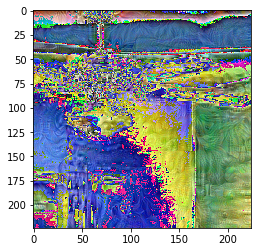

In [12]:
x = torch.load(adv_dir + list_dirs[0])
plt.imshow(np.transpose(x[8].numpy(),[1,2,0]))

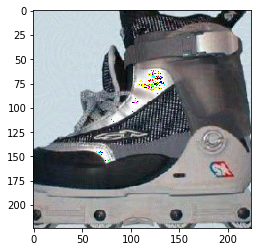

In [5]:
image = np.transpose(x[0].numpy(),[1,2,0])
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
plt.imshow(image)

In [6]:
model_path_test = '/scratch/hle/data/trained_models/caltech_101_gaussian_corrupted/caltech_101_gaussian_corrupted_model_31.ckpt'
img_size = (224,224,3)
BATCH_SIZE = 50
model = SARGAN(img_size, BATCH_SIZE, img_channel=3)
saver = tf.train.Saver()
gpu = "0"
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list=gpu)
config=tf.ConfigProto(gpu_options=gpu_options)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
NOISE_STD = 0.1
recovered_imgs =[]
with tf.Session(config=config) as sess:
    saver.restore(sess, model_path_test)
    i = 0
    while i < 2200:
        batch = test_imgs [i:i + 50]
        batch = [(std * image + mean) for image in batch]
        i += 50
        corrupted_batch = np.array([add_gaussian_noise(image, sd=NOISE_STD) for image in batch])
#         print("corrupted batch range %s, %s" % (np.amax(corrupted_batch), np.amin(corrupted_batch)))
        gen_imgs = sess.run(model.gen_img, feed_dict={model.image:batch, model.cond:corrupted_batch})
        recovered_imgs.append(gen_imgs)
    batch = test_imgs [2192:]
    batch = [(std * image + mean) for image in batch]
    corrupted_batch = np.array([add_gaussian_noise(image, sd=NOISE_STD) for image in batch])
#         print("corrupted batch range %s, %s" % (np.amax(corrupted_batch), np.amin(corrupted_batch)))
    gen_imgs = sess.run(model.gen_img, feed_dict={model.image:batch, model.cond:corrupted_batch})
    gen_imgs = gen_imgs[8:]
    recovered_imgs.append(gen_imgs)
    

W0826 14:02:44.850442 140002637297472 deprecation_wrapper.py:119] From /home/grad3/hle/sargan/sargan_models.py:13: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 14:02:44.855634 140002637297472 deprecation_wrapper.py:119] From /home/grad3/hle/sargan/sargan_models.py:46: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0826 14:02:44.857175 140002637297472 deprecation_wrapper.py:119] From /home/grad3/hle/sargan/utils.py:10: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0826 14:02:47.960741 140002637297472 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, p

In [9]:
recovered_imgs = np.concatenate(recovered_imgs)
print(len(recovered_imgs))

2242


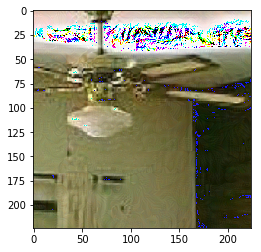

In [14]:
plt.imshow(std * test_imgs[8] + mean)

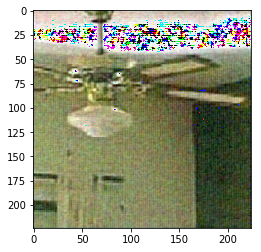

In [15]:
plt.imshow(recovered_imgs[8])

In [10]:
recovered_imgs_save = [(img - mean)/std for img in recovered_imgs]

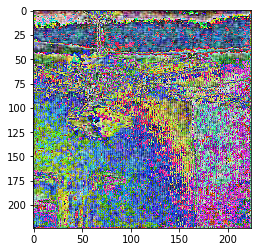

In [11]:
plt.imshow(recovered_imgs_save[8])

In [15]:
i = 0
for _ in range(35):
    current_batch = torch.Tensor(np.transpose(recovered_imgs_save[i:i+64], [0,3, 1, 2]))
    i += 64
    torch.save(current_batch, "/scratch/hle/caltech_adv/img_recover_batch_%s.pt" % _)
current_batch = torch.Tensor(np.transpose(recovered_imgs_save[2240:], [0,3, 1, 2]))
i += 64
torch.save(current_batch, "/scratch/hle/caltech_adv/img_recover_batch_%s.pt" % 35)  

In [17]:
x = torch.load('/scratch/hle/caltech_adv/img_recover_batch_34.pt')
print(x.shape)

torch.Size([64, 3, 224, 224])
